In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# importing crop data of year 2020
# crop_data = pd.read_csv('./data/ndvi/crop_data_ndvi.csv')
# crop_data = pd.read_csv('../data/ndvi/crop_data_ndvi_march_bbox00004.csv')
crop_data = pd.read_csv('../data/ndvi/crop_data_ndvi_march_bbox5x5.csv')

In [3]:
# X = crop_data.drop(columns=['Class of Land', 'Latitude and Longitude', 'ndvi_mean', 'ndvi_max'])
X = crop_data.drop(columns=['Class of Land', 'Latitude and Longitude', 'ndvi_max'])
y = crop_data['Class of Land']

del crop_data

In [4]:
X_train_pn, X_val_pn, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=10)

In [5]:
X_train_pn.head()

,vh,vv,RVI,ndvi_mean,ndvi_min
284,0.025757,0.118033,0.303256,0.358095,0.048155
423,0.003890,0.009123,0.653709,0.700000,0.700000
525,0.002746,0.013569,0.276259,0.700000,0.700000
519,0.008323,0.008974,1.335133,0.700000,0.700000
12,0.005207,0.054431,0.103184,0.223435,0.111036


In [6]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train_pn)
X_val = sc.transform(X_val_pn)

In [7]:
model = RandomForestClassifier(n_jobs=-1)

params = {
    'n_estimators': [10, 100, 500, 1000],
	'criterion': ['gini', 'entropy', 'log_loss'],
	'n_jobs': [-1]
}

grid = GridSearchCV(model, params, n_jobs=-1, verbose=1, cv=50)
grid.fit(X_train, y_train)

grid.best_score_, grid.best_params_

Fitting 50 folds for each of 12 candidates, totalling 600 fits


(0.9271111111111111, {'criterion': 'gini', 'n_estimators': 10, 'n_jobs': -1})

In [8]:
model = grid.best_estimator_

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [9]:
y_pred = model.predict(X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    Non Rice       0.99      1.00      1.00       245
        Rice       1.00      0.99      1.00       235

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



Text(0.5, 1.0, 'Train set Confusion Matrix')

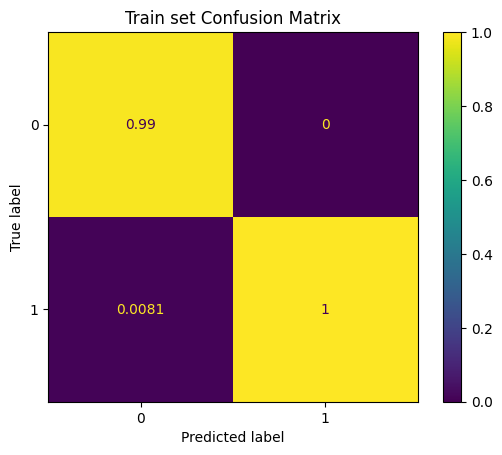

In [10]:
cm = confusion_matrix(y_train, y_pred, normalize='pred')
ConfusionMatrixDisplay(cm).plot()
plt.title('Train set Confusion Matrix')

In [11]:
y_pred = model.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

    Non Rice       0.86      0.98      0.92        55
        Rice       0.98      0.86      0.92        65

    accuracy                           0.92       120
   macro avg       0.92      0.92      0.92       120
weighted avg       0.93      0.92      0.92       120



Text(0.5, 1.0, 'Validation set Confusion Matrix')

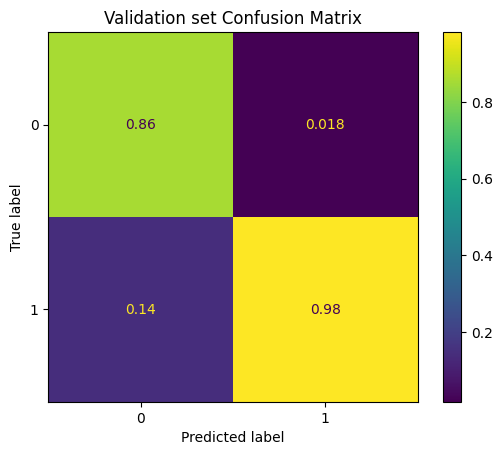

In [12]:
cm = confusion_matrix(y_val, y_pred, normalize='pred')
ConfusionMatrixDisplay(cm).plot()
plt.title('Validation set Confusion Matrix')

In [13]:
feature_importances_df = pd.DataFrame({'Feature': X_train_pn.columns, 'Importance': model.feature_importances_})

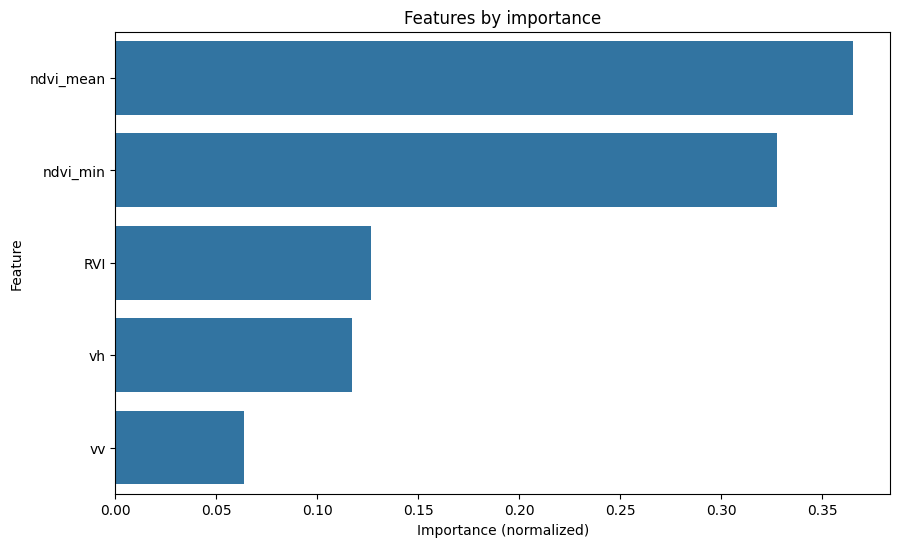

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.sort_values('Importance', ascending=False), orient='h')
plt.xlabel('Importance (normalized)')
plt.ylabel('Feature')
plt.title('Features by importance')
plt.show()

## On submission data

In [15]:
# X_val = pd.read_csv('./data/ndvi/validation_data_ndvi.csv')
X_val = pd.read_csv('../data/ndvi/validation_data_ndvi_march_bbox5x5.csv')
coords = X_val['Latitude and Longitude']
# X_val.drop(columns=['Latitude and Longitude', 'ndvi_mean', 'ndvi_max'], inplace=True)
X_val.drop(columns=['Latitude and Longitude', 'ndvi_max'], inplace=True)

In [16]:
X_val.head()

,vh,vv,RVI,ndvi_mean,ndvi_min
0,0.005058,0.383090,0.005950,0.070417,-0.001752
1,0.001983,0.081168,0.014730,0.170399,0.043861
2,0.017813,0.111093,0.205469,0.711041,0.684168
3,0.003966,0.006158,0.980703,0.700000,0.700000
4,0.020260,0.159520,0.151326,0.015140,-0.002439


In [17]:
X_val = sc.transform(X_val)

In [18]:
y_pred = model.predict(X_val)

In [19]:
submission_df = pd.DataFrame({'id':coords.values, 'target':y_pred})

submission_df.head()

,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice


In [20]:
submission_df.where(submission_df['target'] == 'Non Rice').count()

id        161
target    161
dtype: int64

In [21]:
submission_df.where(submission_df['target'] == 'Rice').count()

id        89
target    89
dtype: int64

In [22]:
y_val.where(y_val == 'Rice').count(), y_val.where(y_val == 'Non Rice').count()

(65, 55)

In [23]:
y_train.where(y_train == 'Rice').count(), y_train.where(y_train == 'Non Rice').count()

(235, 245)

In [24]:
submission_df.to_csv('../data/submissions/challenge_1_submission_rice_crop_prediction_ndvi_march_bbox5x5_StrdSc.csv', index=False)

In [25]:
X_train.shape, X_val.shape, X_val.shape

((480, 5), (250, 5), (250, 5))